### Links:
* http://www.danvk.org/2015/01/07/finding-blocks-of-text-in-an-image-using-python-opencv-and-numpy.html
* http://felix.abecassis.me/2011/10/opencv-rotation-deskewing/

In [1]:
import sys; sys.path.append('scripts/')

In [2]:
from doc2text import *
from helpers import *
from curriedCv import *

In [3]:
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 12, 9 

---

# Black and white without shadow

In [4]:
def plot_letter_line_finding(image, plot=True):
    x = image.copy().astype(np.int32)
    x -= 1
    x[x > 0] = 0
    x = np.abs(x)
    bars = pd.Series(np.sum(x, axis=1))
    bars[bars < bars.mean()] = -1
    bars[bars > 0] = 1
    cb = np.cumsum(bars)
    if plot:
        cb.plot();
    return cb

In [5]:
def nice_black(image):
    return pipe(image, descew, dog, negate, normalize, gaussian, 
                level(black=0.0, white=1, gamma=1), float_to_uint8, to_gray, threshold)

In [6]:
img = load('data/1.jpg')
result = nice_black(img)
f = plot_letter_line_finding(result, plot=False)

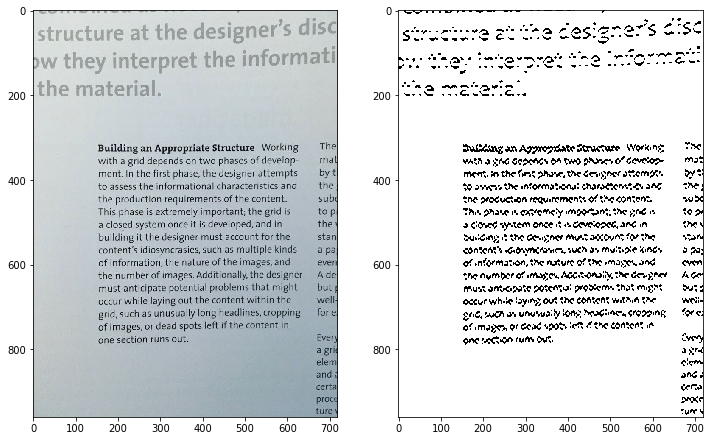

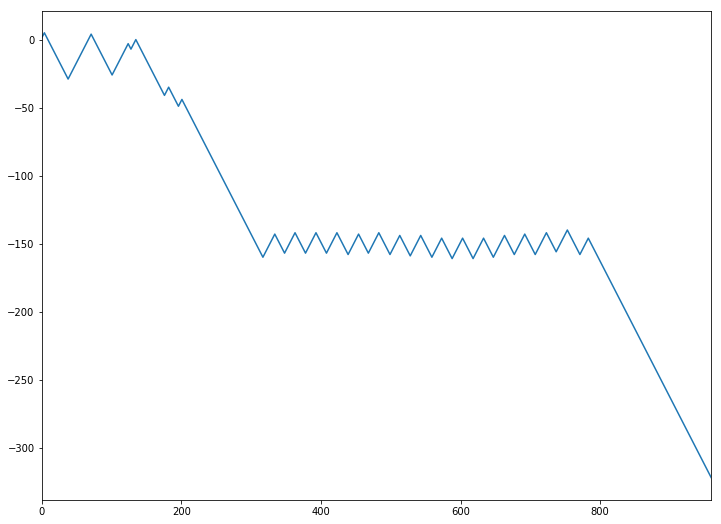

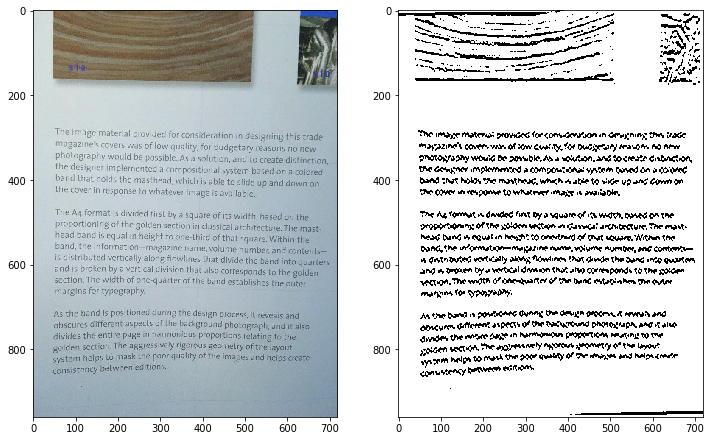

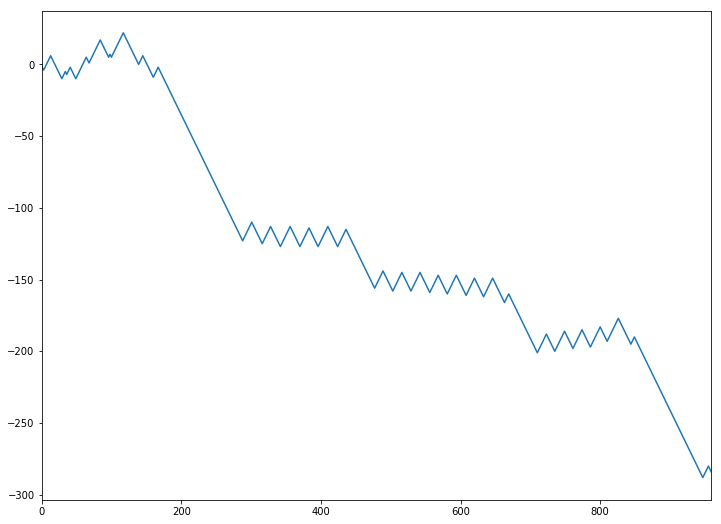

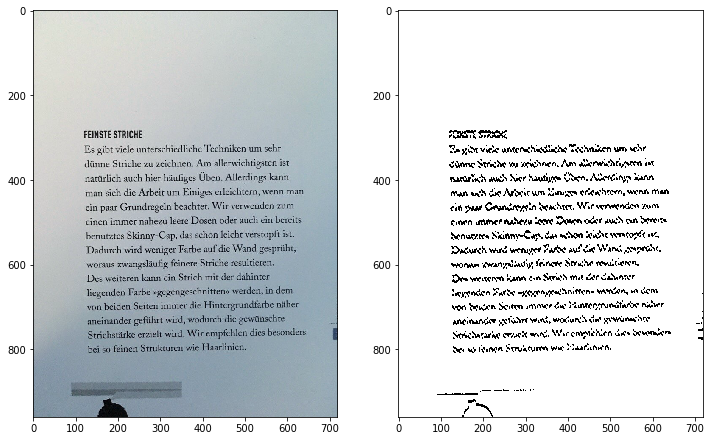

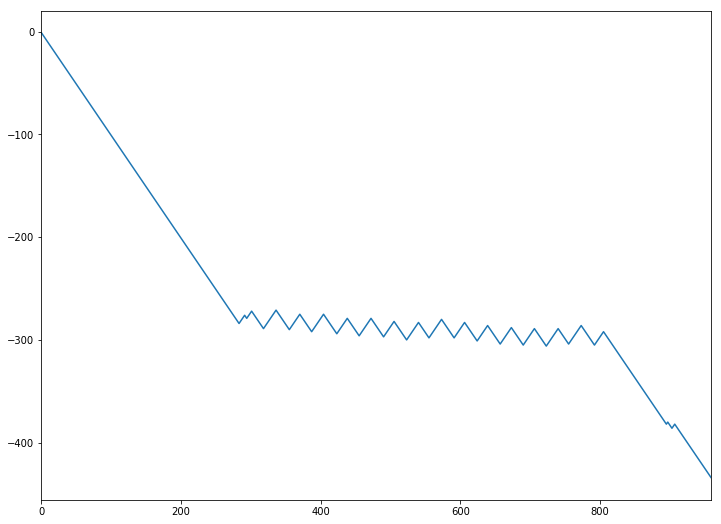

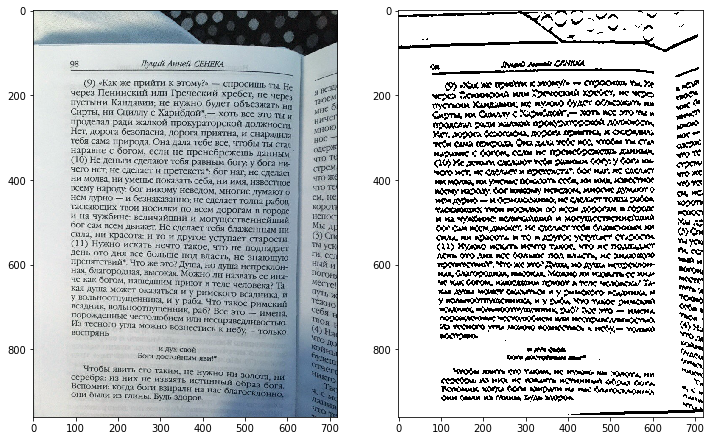

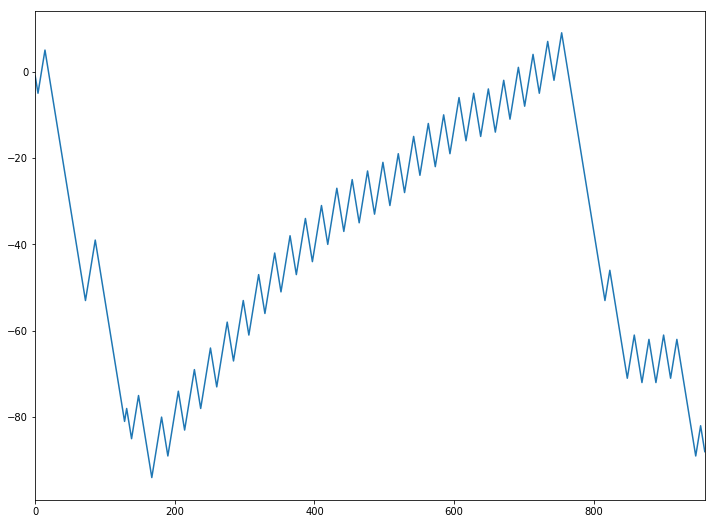

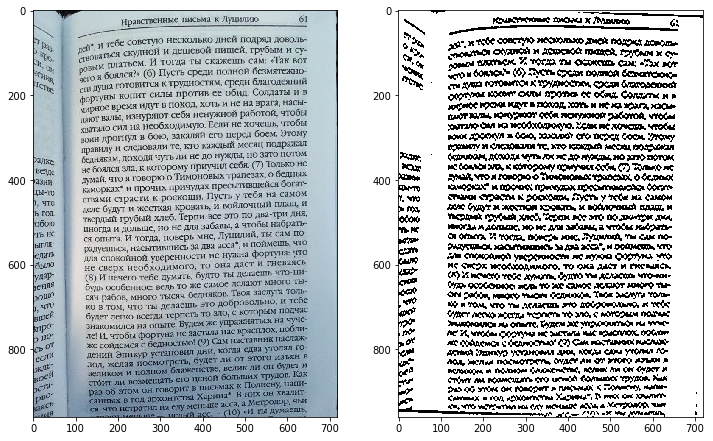

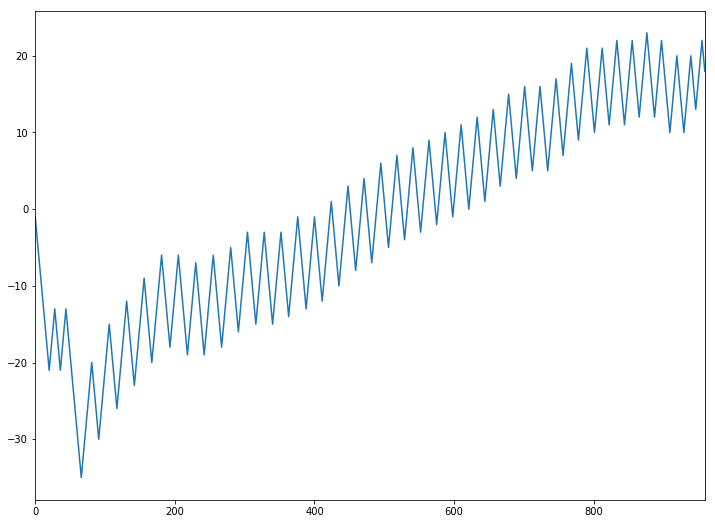

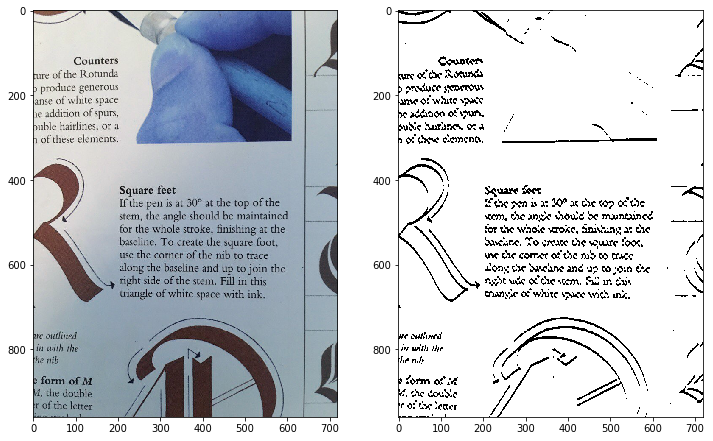

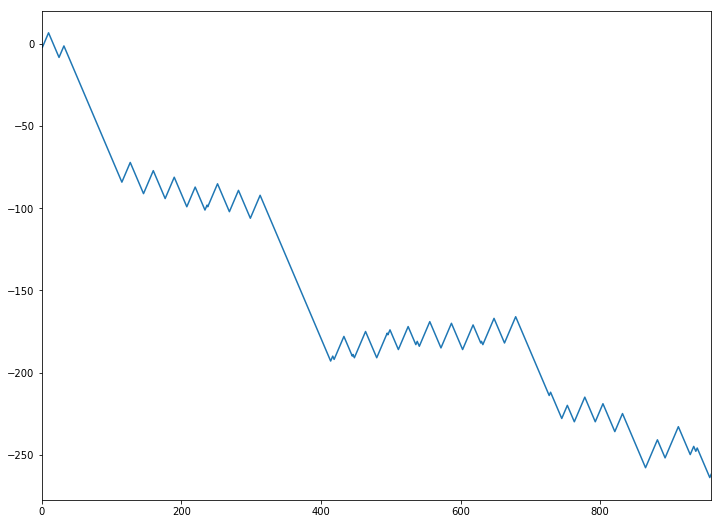

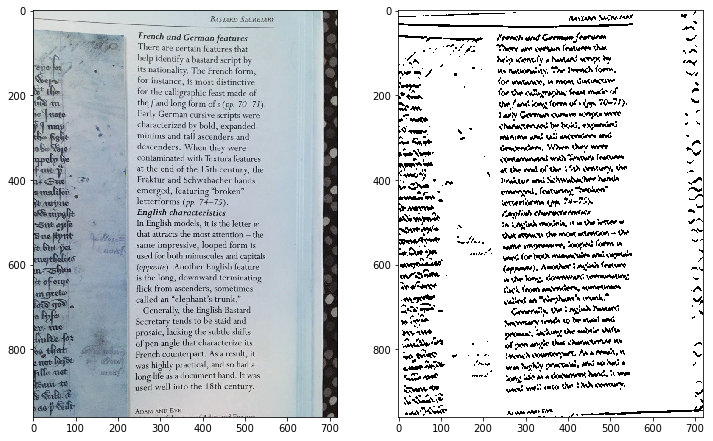

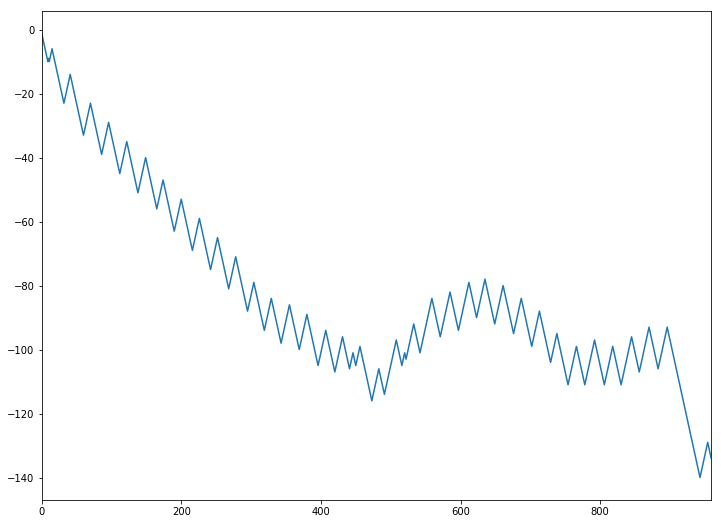

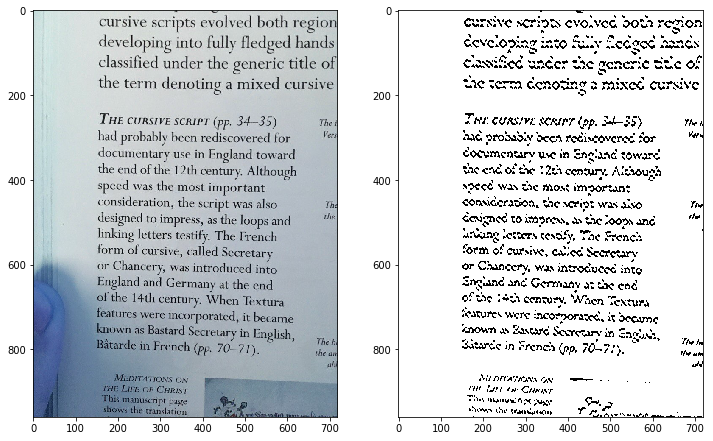

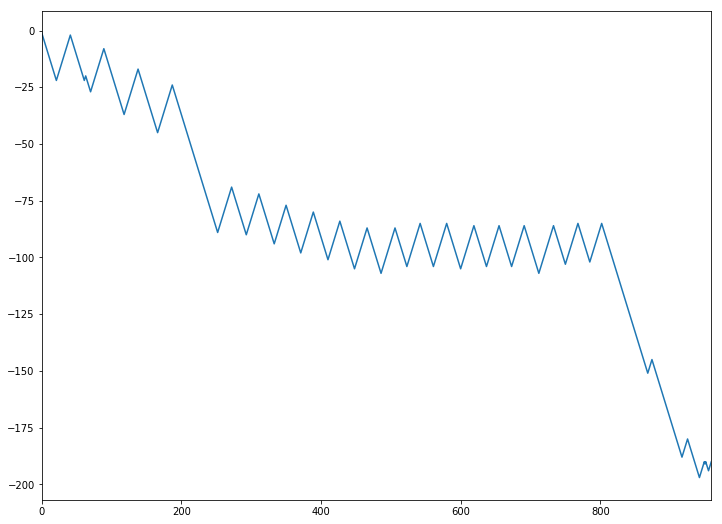

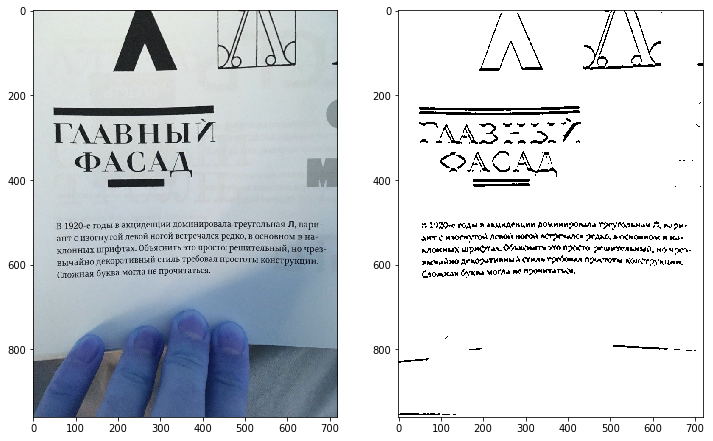

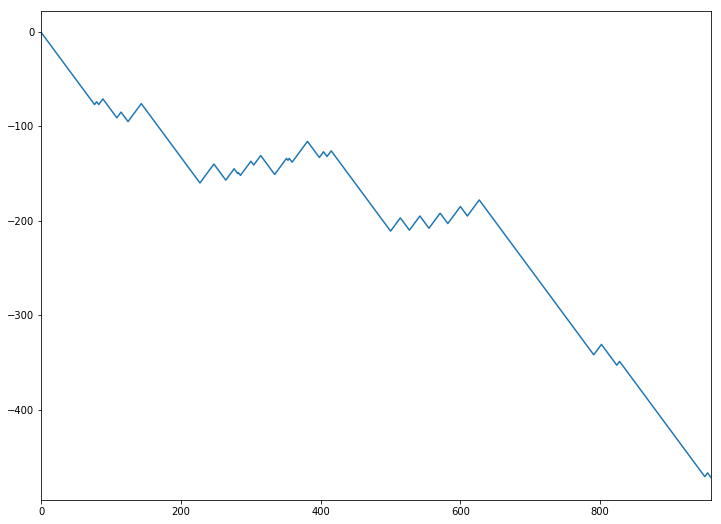

In [7]:
def my_pipe(path):
    img = load(path)
    result = nice_black(img)
    show(img, result)
    return plot_letter_line_finding(result)

[my_pipe('data/{}.jpg'.format(x)) for x in range(1,10)];

# Line height and cropping

In [8]:
from scipy.signal import argrelextrema

In [9]:
f = np.array(f)

In [10]:
px = argrelextrema(f, np.greater)[0]
cx = argrelextrema(f, np.less)[0]

In [11]:
peaks = [f[x] for x in px]
cavities = [f[x] for x in cx]

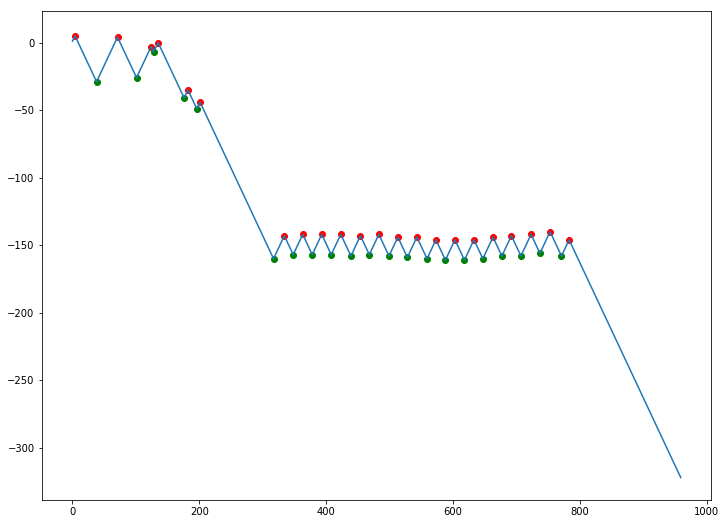

In [12]:
plt.figure()
plt.plot(f);
plt.scatter(px, peaks, c='r');
plt.scatter(cx, cavities, c='g');

In [13]:
dpeaks = [b-a for a,b in zip(px, px[1:])]
dcavs  = [b-a for a,b in zip(cx, cx[1:])]
dxx    = [b-a for a,b in zip(px, cx)]

In [14]:
np.percentile(dcavs, 20), np.median(dcavs), np.percentile(dcavs, 80)

(29.0, 30.0, 31.600000000000005)

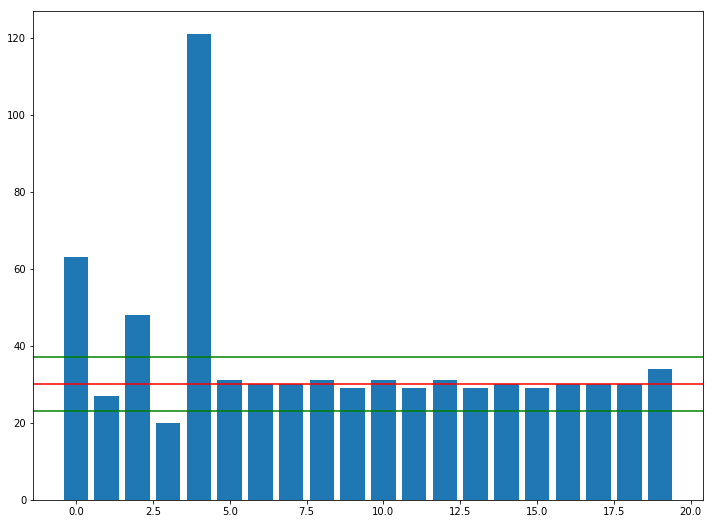

In [15]:
plt.figure()
plt.bar(range(len(dcavs)), dcavs);
plt.axhline(y=np.median(dcavs), color='r');
plt.axhline(y=np.median(dcavs) + np.std(dcavs)/3.0, color='g');
plt.axhline(y=np.median(dcavs) - np.std(dcavs)/3.0, color='g');

In [16]:
lower, upper = np.median(dcavs) - np.std(dcavs)/3.0, np.median(dcavs) + np.std(dcavs)/3.0
beginnings = [x[0] for x in zip(cx, dcavs) if upper >= x[1] >= lower]
line_height = int(np.median(dcavs) * 1.2)
shift = int(np.median(dcavs) * 0.2)

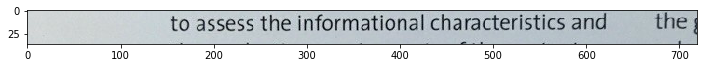

In [17]:
e = beginnings[4]
crop = img[e-shift:e-shift+line_height, 0:img.shape[1]]
show(crop)

# Blocks of text from community

http://stackoverflow.com/a/23672571/4116631

## Blocks with text

In [18]:
img = load('data/9.jpg')
pyrd = cv2.pyrDown(img)
small = to_gray(pyrd)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
grad = cv2.morphologyEx(small, cv2.MORPH_GRADIENT, kernel)

bw = threshold(grad)

h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,1))
connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, h_kernel)

mask = np.zeros(img.shape[:2], np.uint8)
count_image, contours, hierarchy = cv2.findContours(connected, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

rects = [cv2.boundingRect(x) for x in contours]

In [19]:
canvas = pyrd.copy()

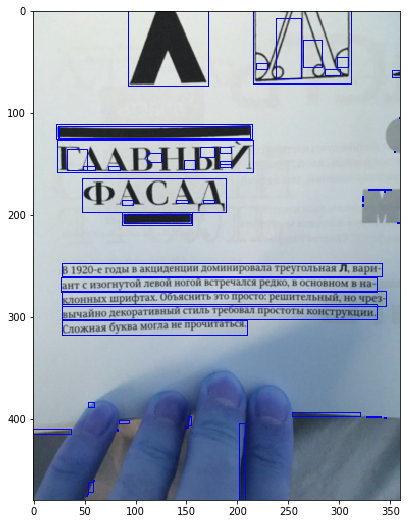

In [20]:
for r in rects:
    cv2.rectangle(canvas, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (0, 0, 255), 1)
show(canvas)

## Filtering rectangles

In [21]:
r = rects[14]

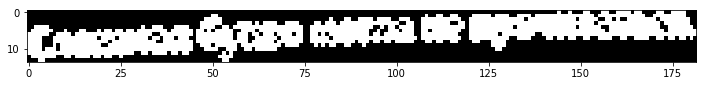

In [22]:
crop = bw[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
show(crop)

In [23]:
cv2.countNonZero(crop) / np.multiply(*crop.shape) 

0.44858712715855575

In [104]:
def points_from_rect(r):
    p1 = (r[0],      r[1])
    p2 = (r[0]+r[2], r[1])
    p3 = (r[0],      r[1]+r[3])
    p4 = (r[0]+r[2], r[1]+r[3])
    return p1, p2, p3, p4

def point_in_rect(p, r):
    return (p[0] >= r[0]) and (p[0] <= r[0]+r[2]) and (p[1] >= r[1]) and (p[1] <= r[1]+r[3])

def rects_close_enough(r1, r2, alpha=4):
    r = (r1[0] - alpha, r1[1] - alpha, r1[2] + 2*alpha, r1[3] + 2*alpha)
    p1, p2, p3, p4 = points_from_rect(r)
    return point_in_rect(p1, r2) \
        or point_in_rect(p2, r2) \
        or point_in_rect(p3, r2) \
        or point_in_rect(p4, r2)

def rects_intersect(r1, r2):
    p1, p2, p3, p4 = points_from_rect(r1)
    contains = point_in_rect(p1, r2) \
        or point_in_rect(p2, r2) \
        or point_in_rect(p3, r2) \
        or point_in_rect(p4, r2)
    close_enough = rects_close_enough(r1, r2)
    return contains or close_enough

In [105]:
def cluster_contains(rect, cluster):
    for another in cluster:
        if rects_intersect(rect, another):
            return True
    return False

In [106]:
clusters = []
for r in rects:
    if len(clusters) == 0:
        clusters.append([r])
    else:
        added = False
        for c in clusters:
            if cluster_contains(r, c):
                c.append(r)
                added = True
        if not added:
            clusters.append([r])

In [107]:
len(clusters)

30

In [108]:
canvas = pyrd.copy()

In [109]:
r = lambda: (np.random.randint(255), np.random.randint(255), np.random.randint(255))

colors = [r() for _ in range(len(clusters))]

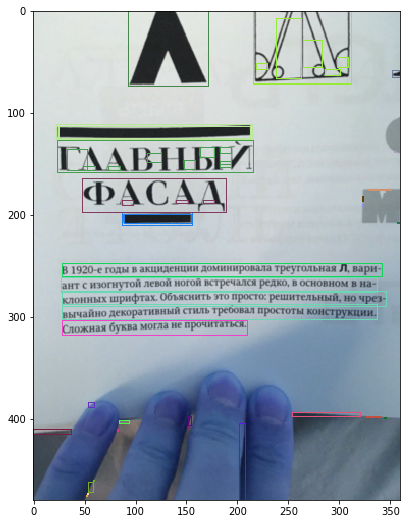

In [110]:
for i, c in enumerate(clusters):
    for r in c:
        color = colors[i]
        cv2.rectangle(canvas, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), color, 1)
show(canvas)